In [1]:
from datascience import *
import numpy as np
import math
import scipy.stats as stats

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

This homework uses the file `baby.csv`, presented in class.  Show your results for the following questions.

In [2]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


## Problem 1

##### 1. Calculate the 90% confidence interval for the <font color=red>median</font> Maternal BMI (body mass index), using the bootstrap method.

The formula for BMI is $$\frac{\text{Weight (lb)}}{\text{[height (in)]}^2} \times 703$$.

In [3]:
BMI = births.select('Maternal Pregnancy Weight', 'Maternal Height').with_column(
    'bmi', births.column('Maternal Pregnancy Weight')/births.column('Maternal Height')/births.column('Maternal Height')*703)
BMI

Maternal Pregnancy Weight,Maternal Height,bmi
100,62,18.2882
135,64,23.1702
115,64,19.7375
125,67,19.5756
93,62,17.0081
178,62,32.5531
140,65,23.2947
125,62,22.8603
136,66,21.9486
120,68,18.2439


21.2822265625

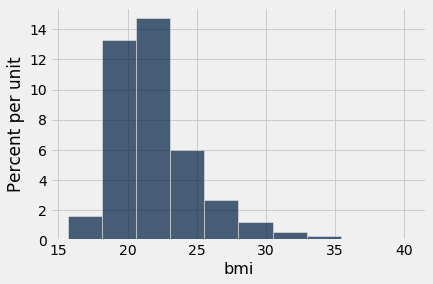

In [4]:
BMI.select('bmi').hist();
np.median(BMI.column(2))

In [5]:
def bootstrap_median(sample, variableLabel, numBootstrap):
    compensation = sample.select(variableLabel)
    medians = make_array()
    for i in np.arange(numBootstrap):
        bootstrap_sample = compensation.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)

    return medians

In [6]:
bstrap_medians = bootstrap_median(BMI, 'bmi', 5000)

In [7]:
left = percentile(5, bstrap_medians)  
right = percentile(95, bstrap_medians)

make_array(left, right) 

array([21.14167966, 21.45385742])

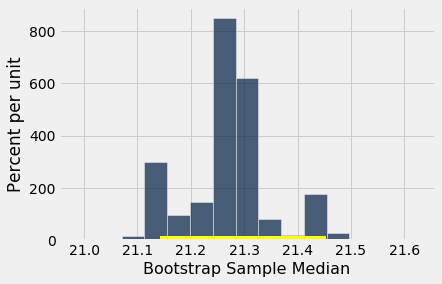

In [8]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
resampled_medians.hist(bins=15)
plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

##### 2.  Calculate the 80% confidence interval for the proportion of mothers who smoked using the bootstrap method.

In [9]:
births.select('Maternal Smoker')

Maternal Smoker
False
False
True
True
False
False
False
False
True
False


In [10]:
age_mean = np.mean(births.column('Maternal Smoker'))
age_mean

0.3909710391822828

In [11]:
def bootstrap_mean(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample means:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(0))
        means = np.append(means, resampled_mean)
        
    return means

In [12]:

bstrap_means = bootstrap_mean(births, 'Maternal Smoker', 5000)

left = percentile(10, bstrap_means)
right = percentile(90, bstrap_means)

make_array(left, right)

array([0.37308348, 0.4088586 ])

## Problem 2

##### 1. Use permutation test to test the following hypotheses using the ratio of the variances as the test statistic.

* $H_0$: The variance of `Birth Weight` is the same as for mothers who smoke and mothers who do not smoke.
* $H_1$:The variance of `Birth Weight` is diferent between mothers who smoke and mothers who do not smoke.

(Note: We saw how to test these hypothesis using the F-ratio test in class.)

In [29]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


In [30]:
var_table = smoking_and_birthweight.group('Maternal Smoker', (lambda x: np.std(x,ddof=1)**2))
var_table

Maternal Smoker,Birth Weight
False,303.585
True,334.707


In [31]:
var1 = var_table.where('Maternal Smoker', True).column(1)[0]
var2 = var_table.where('Maternal Smoker', False).column(1)[0]
make_array(var1, var2)

array([334.70740455, 303.58514819])

In [32]:
n1 = births.where('Maternal Smoker', True).num_rows
n2 = births.where('Maternal Smoker', False).num_rows
make_array(n1, n2)

array([459, 715], dtype=int64)

In [33]:
observed_difference = var1/var2
observed_difference

1.1025157408199457

In [34]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [35]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,False
True,128,True
True,108,True
False,136,True
False,138,False
False,132,False
False,120,False
True,143,False
False,140,True


In [36]:
shuffled_only = original_and_shuffled.drop('Maternal Smoker')
shuffled_group_var_table = shuffled_only.group('Shuffled Label', (lambda x: np.std(x,ddof=1)**2))
shuffled_group_var_table

Shuffled Label,Birth Weight
False,337.172
True,334.751


In [37]:
def ratio_of_vars(table, label, group_label):
    reduced = table.select(label, group_label)
    
    var_table = reduced.group(group_label, (lambda x: np.std(x,ddof=1)**2))
    var = var_table.column(1)
    return var.item(1) /var.item(0)

In [38]:
ratio_of_vars(births, 'Birth Weight', 'Maternal Smoker')

1.1025157408199457

In [39]:
ratio_of_vars(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.9928217359760486

In [40]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    shuffled_table = table.select(label).with_column('Shuffled Label', shuffled_labels)
    return ratio_of_vars(shuffled_table, label, 'Shuffled Label')   

In [41]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

0.9322587946857662

In [42]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)                               

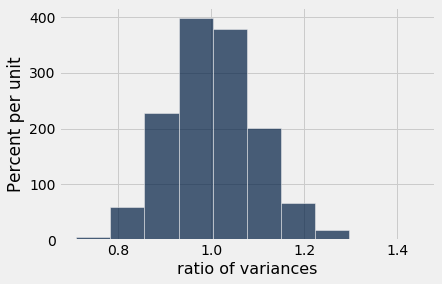

In [43]:
diffTable = Table().with_column('ratio of variances', differences)
diffTable.hist()

In [44]:
empirical_P =(1- np.count_nonzero(differences <= observed_difference) / repetitions)*2
empirical_P

0.2924

P>0.05. We do not have enough evidence to reject the null hypothesis. The variance of Birth Weight is the same as for mothers who smoke and mothers who do not smoke.